In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\dguse\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dguse\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\dguse\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Let's try to replicate the [Cbonds USA Corporate Index](https://cbonds.ru/download/indexdocs/indexdescrs/1230) based on the prices of bonds ever included there

## 0. Data loading and preparation

In [2]:
# read index structure
# an International Securities Identification Number (ISIN) uniquely identifies a security.
structure = pd.read_excel(r'cbonds-usa-corporate-index.xlsx',
                      sheet_name='structure')

structure['Index Structure Date'] = pd.to_datetime(structure['Index Structure Date'], format="%d.%m.%Y")

structure.head()

,Index Structure Date,Issue name,ISIN,"Issue amount, USDmn",Issue currency,Maturity date
0,2023-04-01,"AT&T Inc, 1.65% 1feb2028, USD",US00206RKG64,2250.000,USD,2028-02-01 00:00:00
1,2023-04-01,"AT&T Inc, 1.7% 25mar2026, USD",US00206RML32,3000.000,USD,2026-03-25 00:00:00
2,2023-04-01,"AT&T Inc, 2.25% 1feb2032, USD",US00206RKH48,2500.000,USD,2032-02-01 00:00:00
3,2023-04-01,"AT&T Inc, 2.3% 1jun2027, USD",US00206RJX17,2500.000,USD,2027-06-01 00:00:00
4,2023-04-01,"AT&T Inc, 2.55% 1dec2033, USD",US00206RMM15,3754.161,USD,2033-12-01 00:00:00


In [3]:
# read bonds quotes
quotes = pd.read_csv(r'quotes.csv',
                     usecols=['Trade date', 'Indicative price, %', 'ISIN', 'ACI'],
                     parse_dates=['Trade date'])


quotes.drop_duplicates(inplace=True)
quotes.head()

,Trade date,"Indicative price, %",ACI,ISIN
0,2023-04-10,88.02065,6.33,US00206RKG64
1,2023-04-07,88.54125,6.05,US00206RKG64
2,2023-04-06,88.87270,5.96,US00206RKG64
3,2023-04-05,89.00250,5.87,US00206RKG64
4,2023-04-04,88.69000,5.78,US00206RKG64


In [4]:
quotes.shape

(739064, 4)

## 1. From net to dirty prices

* Accrued coupon interest (ACI, Accrued Interest) is a value measured in monetary units, and characterizing the part of coupon income, which has "accrued" from the beginning of the coupon period

* In most markets, bonds are traded at net prices (excluding ACI) and sales transactions are made at a dirty price (including ACI), which means that when the transaction price of the bond for the buyer is made up of two components: the market price and the accumulated coupon income for the relevant period

![ACI](bond-price-graph-accrued-interest.svg)


* Be careful! Many data vendors mess up their data. Bond price estimates can be distorted by short-term liquidity shortages in the markets.

In [5]:
bonds_desc = pd.read_excel(r'cbonds-usa-corporate-index.xlsx',
                      sheet_name='bonds_desc_15.04.2023',
                      usecols=['ISIN', 'Coupon frequency', 'Nominal / Minimum Settlement Amount'])


# create mapping isin: nominal/settlement amount
mapping_isin_nominal = dict(zip(bonds_desc['ISIN'], bonds_desc['Nominal / Minimum Settlement Amount']))
mapping_isin_nominal.update

# calculate ACI as % of nominal/settling amount
quotes['ACI, %'] = quotes['ACI'] * 100 / quotes['ISIN'].map(mapping_isin_nominal)

In [6]:
quotes['ACI, %'].isna().sum()

26133

In [7]:
example_isin ='US00206RCP55'

example = quotes.set_index(['ISIN', 'Trade date']).sort_index().loc[example_isin,:]
example.head()

,"Indicative price, %",ACI,"ACI, %"
Trade date,,,
2016-01-01,93.275,11.50,0.5750
2016-01-04,93.480,12.25,0.6125
2016-01-05,92.970,12.50,0.6250
2016-01-06,93.310,12.75,0.6375
2016-01-07,92.965,13.00,0.6500


Text(0.5, 1.0, 'US00206RCP55 price decomposition')

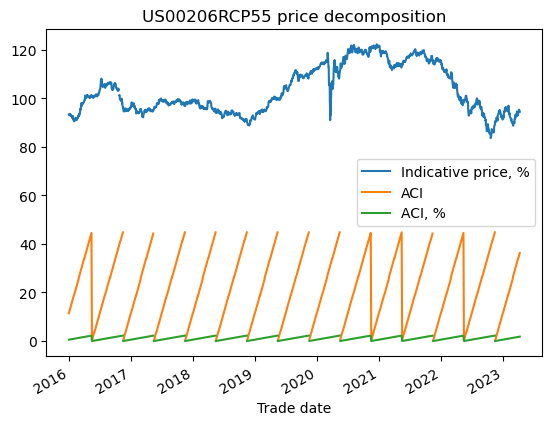

In [8]:
example.plot()
plt.title(f'{example_isin} price decomposition')

In [9]:
example['ACI, %'].fillna(0, inplace=True) # filling the gaps
coupon_event = example['ACI, %'] > example['ACI, %'].shift(-1) # time of coupon payment = zeroing of ACI
coupons = example['ACI, %'][coupon_event] + example['ACI, %'].shift(-2)[coupon_event] # T+2 settlement
coupon_yield = coupons / example['Indicative price, %'] # make adjustment for nominal as ACI not in % of nominal

In [10]:
coupons

Trade date
2016-05-13    2.250
2016-11-14    2.250
2017-05-12    2.225
2017-11-14    2.250
2018-05-14    2.250
2018-11-14    2.250
2019-05-14    2.250
2019-11-14    2.275
2020-05-14    2.275
2020-11-13    2.250
2021-05-14    2.275
2021-11-12    2.225
2022-05-13    2.250
2022-11-14    2.250
Name: ACI, %, dtype: float64

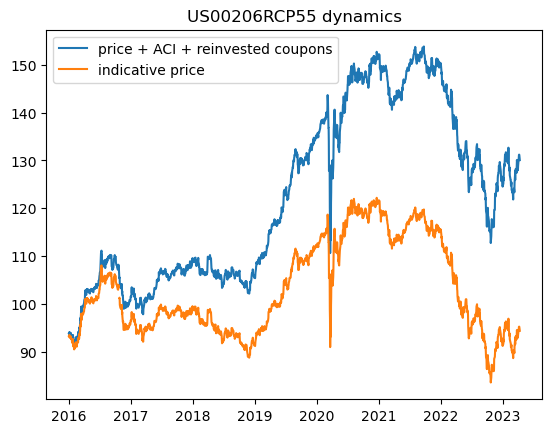

In [11]:
rets = example['Indicative price, %'].pct_change().fillna(0) + coupon_yield.fillna(0)
price = pd.Series((np.ones_like(rets) + rets), index=example.index).cumprod() * example['Indicative price, %'][0]
price = (price + example['ACI, %'][~coupon_event]).fillna(method='ffill')
plt.plot(price, label='price + ACI + reinvested coupons')
plt.plot(example['Indicative price, %'], label='indicative price')
plt.title(f'{example_isin} dynamics')
plt.legend()

In [12]:
# wrap into function to calculate total bond return / dirty price

def calc_tr(quotes):
    '''
    Calculates dirty prices 
    
    Input - DataFrame,  columns: 'Trade date', 'ISIN', 'Indicative price, %', 'ACI, %'
    Output - sorted Initial DataFrame with additional 'dirty_price' column
    '''
    q = quotes.copy()
    q['dirty_price'] = np.zeros_like(q.ISIN)
    isins = q.ISIN.unique()
    q = q.set_index(['ISIN', 'Trade date']).sort_index()
    
    for isin in isins:
        dt = q.loc[isin,:]
        dt['ACI, %'].fillna(0, inplace=True)
        coupon_event = dt['ACI, %'] > dt['ACI, %'].shift(-1)
        coupons = dt['ACI, %'][coupon_event] + dt['ACI, %'].shift(-2)[coupon_event]
        coupon_yield = coupons / dt['Indicative price, %'] # make adjustment for nominal, ACI not in % of nominal

        rets = dt['Indicative price, %'].pct_change().fillna(0) + coupon_yield.fillna(0) # cbonds provides incorrect data
        price = pd.Series((np.ones_like(rets) + rets), index=dt.index).cumprod() * dt['Indicative price, %'][0]
        price = (price + dt['ACI, %'][~coupon_event]).fillna(method='ffill')
        q.loc[isin,'dirty_price'] = price.values

    return q

## 2. Constructing index

In [13]:
import vectorbt as vbt

In [14]:
# create dataframe of dirty prices

prices = calc_tr(quotes).dirty_price.unstack().T.fillna(method='ffill')

In [18]:
# Cbonds index is weighted by outstanding amount

amount = structure.groupby('Index Structure Date')['Issue amount, USDmn'].sum() # sum of outstanding value of bonds at each date
structure['weights'] = structure.apply(lambda x: x['Issue amount, USDmn'] / amount.loc[x['Index Structure Date']], axis=1) # weights of bonds at each date

# transforming to DataFrame: columns - bonds, rows - dates, values - weights

w = structure[['Index Structure Date', 'ISIN', 'weights']].set_index(['Index Structure Date', 'ISIN'])
w = w.unstack().fillna(0)
w = w.reindex(prices.index).fillna(method='ffill')
w = w['weights'][prices.columns]

In [19]:
# index, that we are trying to replicate

cbonds_index = pd.read_excel(r'cbonds-usa-corporate-index.xlsx',
                      sheet_name='index_value',
                      index_col=0)

In [20]:
bond_pf = vbt.Portfolio.from_orders(
    close=prices,
    size=w,
    size_type='targetpercent',
    direction='longonly',
    group_by=True,
    cash_sharing=True
)

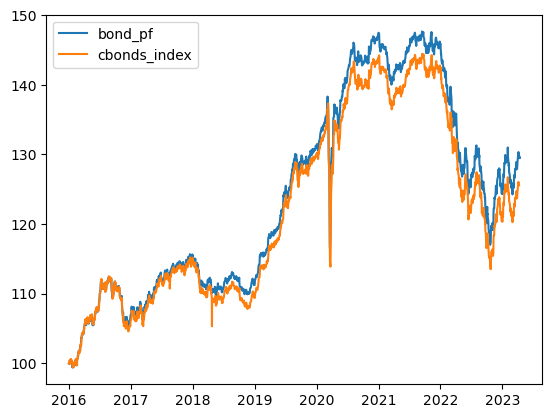

In [21]:
plt.plot(bond_pf.value(), label='bond_pf')
plt.plot(cbonds_index, label='cbonds_index')
plt.legend()

Text(0.5, 1.0, 'gross exposure')

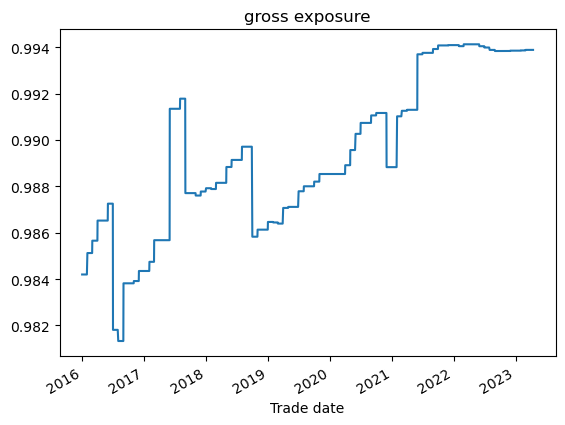

In [22]:
# we replicated ~99% of index

w.sum(axis=1).plot()
plt.title('gross exposure')

Text(0.5, 1.0, 'HH index')

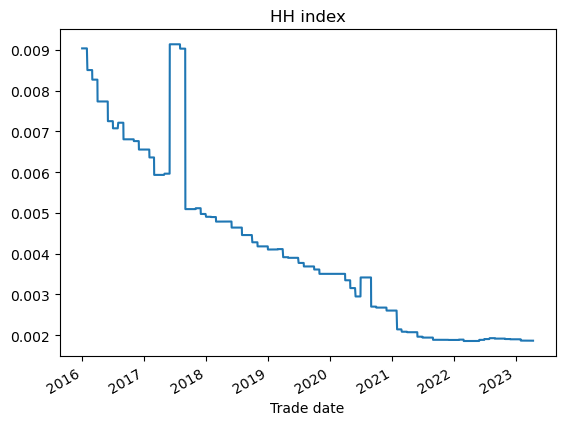

In [23]:
# calculate Herfindahl-Hirschman index to estimate portfolio concentration

(w ** 2).sum(axis=1).plot()
plt.title('HH index')

In [24]:
# time of returns max divergence is crisis time

(bond_pf.value().pct_change() - cbonds_index['Cbonds USA Corporate USD Index'].pct_change()).idxmax()

Timestamp('2020-03-25 00:00:00')

In [25]:
# calculate tracking error

tracking_error = (bond_pf.value().pct_change() - cbonds_index['Cbonds USA Corporate USD Index'].pct_change()).std() * 252 ** 0.5

print('Tracking error - {:0.2f}%'.format(tracking_error*100))

Tracking error - 11.63%


Discrepancy may be due to errors in the raw data, incomplete replication of the portfolio

# Project 2 - Quantitative bond strategy

### Task
- Build a quantitative strategy and overtake the Cbonds Corporate USD Index by Sharpe Ratio on backtest
- Use any idea, any additional features and any quantitative framework you want
- Backtesting: Sharpe & Calmar Ratios, Accumulted Return / Maximum Drawdown
- Risk Measures: Calculate 5% VaR using PCA and backtest it
- Diversification Measures: Calculate dynamics of Herfindahl-Hirschman Index and Intra-portfolio correlation (IPC), compare it to Cbonds Index
- Save all your backtest attempts and calculate the probability of backtest overfitting. Would you trust your results?
- Results: Jupyter Notebook with detailed comments and docstrings where applicable. **Please describe in the beginning of the file the methodology you used!**
- Deadline: 31.03.2024 23:59 MSK. Please send you code to igor.evsin@squants.education

### Data
- Data Frame: 2016-2021 – training + validation (if applicable), 2022-today – testing
- Dataset: see attached to this notebook
- Transaction cost: 0,1% per trade, no fixed costs

### Limits on backtest
- Initial Capital: mn$20
- Total return > 0
- Max Drawdown: < 10%
- Max Drawdown Period: < 3M
- No leverage
- Execution: Next Open price

### Grading
- Try to write code elegantly - points will be taken off for shitty coding.
- Vectorize calculations! (we will take points off for reckless use of loops)
- Points will be deducted for breaking backtest limits
- Points will be deducted for having biases in the backtest
- Those who get a Sharpe 2x< on the backtest without obvious biases will get extra points

# Section 1. Creating a strategy

### Uploading data

In [192]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
import quandl
quandl.ApiConfig.api_key = 'X_FYbmsz5eLDV6zapCRY'

In [111]:
rates = quandl.get("USTREASURY/HQMYC")

# rates = pd.read_csv('rates.csv', index_col='Month')

rates.head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,95.5,96.0,96.5,97.0,97.5,98.0,98.5,99.0,99.5,100.0
Month,,,,,,,,,,,,,,,,,,,,,
1984-01-31,11.02,11.14,11.26,11.38,11.49,11.61,11.73,11.85,11.97,12.09,...,8.41,8.41,8.41,8.40,8.40,8.40,8.39,8.39,8.38,8.38
1984-02-29,11.00,11.13,11.27,11.42,11.57,11.73,11.89,12.04,12.17,12.29,...,10.25,10.25,10.25,10.25,10.24,10.24,10.24,10.24,10.24,10.23
1984-03-31,12.32,12.08,11.91,11.85,11.89,12.01,12.17,12.33,12.49,12.63,...,10.64,10.64,10.63,10.63,10.63,10.63,10.63,10.62,10.62,10.62
1984-04-30,12.55,12.33,12.19,12.15,12.21,12.35,12.52,12.69,12.84,12.98,...,10.98,10.98,10.98,10.98,10.98,10.97,10.97,10.97,10.97,10.97
1984-05-31,13.48,13.14,12.89,12.80,12.86,13.02,13.22,13.42,13.59,13.72,...,12.13,12.13,12.13,12.13,12.13,12.13,12.13,12.13,12.13,12.13


In [168]:
rates_copy = rates.copy()

In [169]:
yields_filtered = rates_copy[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]] * 0.01

### Calculating bond prices for the given maturities (Assume that they are all zero-coupon bonds)

In [170]:
for column in rates_copy.columns:
    rates_copy[column] = 100/(1+rates_copy[column].values * 0.01)**float(column)

In [171]:
rates_copy.head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,95.5,96.0,96.5,97.0,97.5,98.0,98.5,99.0,99.5,100.0
Month,,,,,,,,,,,,,,,,,,,,,
1984-01-31,94.907250,89.976606,85.210167,80.609379,76.192147,71.926789,67.827483,63.893407,60.123250,56.515250,...,0.044759,0.042988,0.041287,0.040009,0.038428,0.036909,0.035774,0.034361,0.033309,0.031995
1984-02-29,94.915800,89.984703,85.198680,80.551511,76.055639,71.695286,67.488619,63.461101,59.642352,56.013743,...,0.008971,0.008544,0.008137,0.007750,0.007446,0.007092,0.006754,0.006433,0.006127,0.005889
1984-03-31,94.356420,89.221984,84.468865,79.933352,75.513016,71.158963,66.900826,62.808289,58.882654,55.173379,...,0.006403,0.006087,0.005838,0.005550,0.005277,0.005017,0.004770,0.004576,0.004351,0.004137
1984-04-30,94.259960,89.023413,84.152840,79.506282,74.975798,70.514880,66.175307,62.009536,58.065230,54.324051,...,0.004777,0.004534,0.004304,0.004086,0.003878,0.003714,0.003526,0.003347,0.003177,0.003016
1984-05-31,93.872922,88.386070,83.371342,78.592626,73.900927,69.268230,64.754354,60.428446,56.359814,52.579414,...,0.001785,0.001685,0.001592,0.001503,0.001419,0.001340,0.001266,0.001195,0.001129,0.001066


In [172]:
prices_filtered = rates_copy[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy()

### Calculating returns on the bonds

In [173]:
rates_copy = np.log(rates_copy / rates_copy.shift(1))
rates_copy = rates_copy.dropna()

In [174]:
rates_copy.head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,95.5,96.0,96.5,97.0,97.5,98.0,98.5,99.0,99.5,100.0
Month,,,,,,,,,,,,,,,,,,,,,
1984-02-29,0.000090,0.000090,-0.000135,-0.000718,-0.001793,-0.003224,-0.005008,-0.006789,-0.008031,-0.008913,...,-1.607282,-1.615697,-1.624112,-1.641475,-1.641093,-1.649508,-1.667011,-1.675473,-1.693116,-1.692552
1984-03-31,-0.005911,-0.008512,-0.008603,-0.007704,-0.007160,-0.007509,-0.008748,-0.010340,-0.012819,-0.015116,...,-0.337227,-0.338993,-0.332036,-0.333756,-0.344321,-0.346086,-0.347852,-0.340669,-0.342389,-0.353181
1984-04-30,-0.001023,-0.002228,-0.003748,-0.005357,-0.007140,-0.009093,-0.010904,-0.012799,-0.013980,-0.015514,...,-0.293024,-0.294558,-0.304815,-0.306394,-0.307974,-0.300722,-0.302257,-0.312740,-0.314319,-0.315899
1984-05-31,-0.004115,-0.007185,-0.009330,-0.011558,-0.014440,-0.017837,-0.021706,-0.025828,-0.029811,-0.032642,...,-0.984501,-0.989655,-0.994810,-0.999964,-1.005118,-1.019104,-1.024303,-1.029503,-1.034702,-1.039902
1984-06-30,-0.000484,-0.001325,-0.002788,-0.004605,-0.006858,-0.009541,-0.012652,-0.015136,-0.017397,-0.019308,...,-0.272153,-0.265040,-0.266420,-0.267801,-0.269181,-0.270562,-0.271942,-0.273323,-0.274703,-0.276083


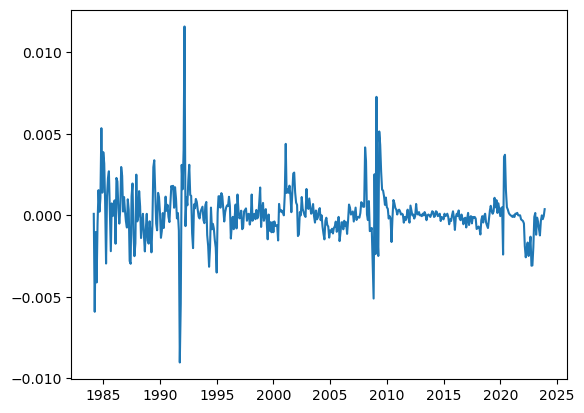

In [175]:
plt.plot(rates_copy["0.5"])
None

### Create a strategy for each maturity.

#### But first it is important to pick the most liquid maturities, suitable for trading. It is generally impossible to find 100-year bonds with adequate bid-ask spreads and relevat volume traded

In [176]:
rates_filtered = rates_copy[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy()

In [177]:
# Function to calculate moving averages
def calculate_moving_average(data, maturity, window):
    moving_average = data[maturity].rolling(window=window).mean()
    return moving_average

# Function to calculate yield spreads
def calculate_yield_spreads(data, maturity_1, maturity_2):
    yield_spreads = data[maturity_1] - data[maturity_2]
    return yield_spreads

def bond_trading_strategy(prices, yields, short_maturity, long_maturity, ma_window):
    signals = pd.DataFrame(index=prices.index)
    
    # Calculate moving averages
    prices['MA_' + short_maturity] = calculate_moving_average(prices, short_maturity, ma_window)
    prices['MA_' + long_maturity] = calculate_moving_average(prices, long_maturity, ma_window)
    
    # Calculate yield spreads
    yield_spreads = calculate_yield_spreads(yields, short_maturity, long_maturity)
    
    # Generate trading signals based on moving average crossover and yield spreads
    signals['Signal'] = 0
    signals.loc[prices['MA_' + short_maturity] > prices['MA_' + long_maturity], 'Signal'] = 1  # Buy signal
    signals.loc[prices['MA_' + short_maturity] < prices['MA_' + long_maturity], 'Signal'] = -1  # Sell signal
    signals.loc[yield_spreads > 0, 'Signal'] = 1  # Buy signal if yield spread is positive
    signals.loc[yield_spreads < 0, 'Signal'] = -1  # Sell signal if yield spread is negative
    
    return signals

def calculate_returns(returns, strategy_signals):
    returns['Strategy_Return'] = returns.mean() * strategy_signals['Signal']
    return returns

In [178]:
# Define parameters for the trading strategy
ma_window = 2

# Iterate over all possible maturity pairs and calculate returns
all_returns = pd.DataFrame()
for short_maturity in yields_filtered.columns:
    for long_maturity in yields_filtered.columns:
        if short_maturity != long_maturity:
            strategy_signals = bond_trading_strategy(prices_filtered, yields_filtered, short_maturity, long_maturity, ma_window)
            returns = calculate_returns(rates_filtered[short_maturity], strategy_signals)
            all_returns[short_maturity + "+" + long_maturity] = returns['Strategy_Return']

# Combine returns for all maturity pairs
all_returns['Total_Return'] = all_returns.sum(axis=1)

### Plotting the cumulative returns

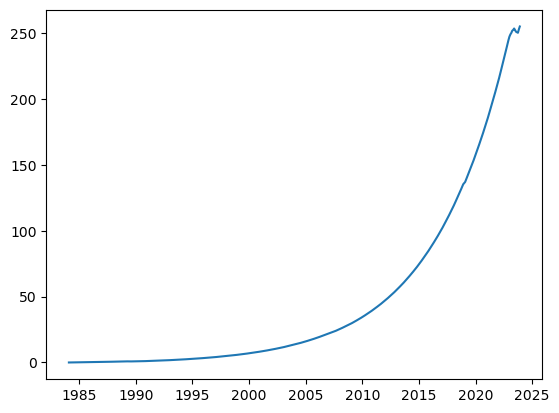

In [179]:
plt.plot((1 + all_returns['Total_Return']).cumprod() - 1 )
None

### Calculating cumulative returns on the given bonds without a strategy

# Section 2. Using strategy on the test sample

In [214]:
train = rates[(rates.index >= pd.to_datetime("2016-01-01")) & (rates.index <= pd.to_datetime("2021-12-31"))]
test = rates[rates.index >= pd.to_datetime("2022-01-01")]

In [215]:
from statsmodels.tsa.arima.model import ARIMA

In [216]:
forecasts = pd.DataFrame()
forecasts.index = test.index
for column in train.columns:
    model = ARIMA(train[column], order=(0,1,0))
    model_fit = model.fit()
    forecasts[column] = model_fit.forecast(steps=len(test))

In [217]:
# For test
yields_filtered = test[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy() * 0.01

for column in test.columns:
    test[column] = 100/(1+test[column].values * 0.01)**float(column)

prices_filtered = test[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy()

test = np.log(test / test.shift(1))
test = test.dropna()
rates_filtered_test = test[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy()

In [218]:
# For the forecasts

yields_filtered = forecasts[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy() * 0.01

for column in test.columns:
    forecasts[column] = 100/(1+forecasts[column].values * 0.01)**float(column)

prices_filtered = forecasts[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy()

forecasts = np.log(forecasts / forecasts.shift(1))
forecasts = forecasts.dropna()
rates_filtered = forecasts[["1.0","2.0", "5.0","8.0", "10.0", "15.0"]].copy()

In [219]:
# Define parameters for the trading strategy
ma_window = 2

# Iterate over all possible maturity pairs and calculate returns
all_returns = pd.DataFrame()
for short_maturity in yields_filtered.columns:
    for long_maturity in yields_filtered.columns:
        if short_maturity != long_maturity:
            strategy_signals = bond_trading_strategy(prices_filtered, yields_filtered, short_maturity, long_maturity, ma_window)
            returns = calculate_returns(rates_filtered_test[short_maturity], strategy_signals)
            all_returns[short_maturity + "+" + long_maturity] = returns['Strategy_Return']

# Combine returns for all maturity pairs
all_returns['Total_Return'] = all_returns.sum(axis=1)

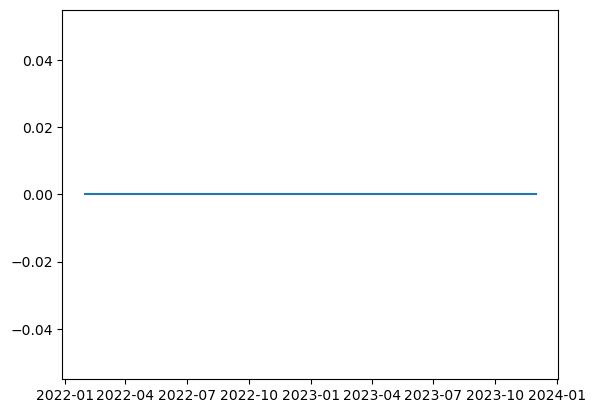

In [220]:
plt.plot(all_returns['Total_Return'])
None

In [ ]:
### The strategy was not sucessfull at all. The main dependencies of the Bond yields have been determined incorrectly. 